In [7]:
import requests
import pandas as pd
from io import StringIO

# SPARQL Query
query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX schema: <http://schema.org/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?family_id ?family_id_label (COUNT(?wikidata_id) AS ?count) ?wiki ?lang ?gbif_id WHERE {
  ?wikidata_id wdt:P31 wd:Q16521 . # instance of taxon
  ?wikidata_id wdt:P105 wd:Q7432 . # taxon rank species
  ?wikidata_id wdt:P171+ wd:Q5113 . # parent taxon+ Aves (Birds)
  ?wikidata_id wdt:P171+ ?family_id . # Get parent taxa until family
  ?family_id wdt:P105 wd:Q35409 . # taxon rank family
  ?family_id wdt:P225 ?family_id_label . # family name
  ?family_id  wdt:P846 ?gbif_id .
  
  # Get Wikipedia link
  ?wikipedia_id schema:about ?wikidata_id .
  ?wikipedia_id schema:isPartOf ?wiki .
  VALUES ?lang {"es" "en"} # Filter by language
  ?wikipedia_id schema:inLanguage ?lang . 
  FILTER(CONTAINS(STR(?wiki), "wikipedia")) # Ensure it's a Wikipedia link
}
GROUP BY ?family_id ?family_id_label ?gbif_id ?wiki ?lang 
ORDER BY DESC(?count)
"""

# SPARQL endpoint URL
endpoint_url = "https://qlever.cs.uni-freiburg.de/api/wikidata"

# Headers for the request
headers = {
    'Accept': 'text/csv' # Request CSV format for easier parsing with pandas
}

# Parameters for the request
params = {
    'query': query
}

# Send the request
try:
    response = requests.get(endpoint_url, headers=headers, params=params)
    response.raise_for_status() # Raise an exception for bad status codes

    # Read the CSV response into a pandas DataFrame
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)

    # Convert count column to numeric, coercing errors
    df['count'] = pd.to_numeric(df['count'], errors='coerce')
    df.dropna(subset=['count'], inplace=True) # Remove rows where count couldn't be converted
    df['count'] = df['count'].astype(int)

    # Filter rows where the language is 'en' and count is greater than 100
    en_filtered_df = df[(df['lang'] == 'en') & (df['count'] > 100)]

    # Get the family_id of rows that satisfy the above condition
    valid_family_ids = en_filtered_df['family_id'].unique()

    # Filter rows where the family_id is in the valid_family_ids
    filtered_df = df[df['family_id'].isin(valid_family_ids)]

    # Display the filtered results
    print("Bird families with more than 100 species on English Wikipedia:")
    print(filtered_df[['family_id_label', 'count']].to_string(index=False))

except requests.exceptions.RequestException as e:
    print(f"Error executing SPARQL query: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


filtered_df.head()

Bird families with more than 100 species on English Wikipedia:
family_id_label  count
     Tyrannidae    451
     Tyrannidae    446
     Thraupidae    395
     Thraupidae    381
    Trochilidae    374
    Trochilidae    372
   Muscicapidae    366
     Columbidae    346
    Psittacidae    345
     Columbidae    338
    Furnariidae    337
    Psittacidae    334
   Muscicapidae    330
    Furnariidae    328
   Accipitridae    262
        Picidae    258
   Accipitridae    256
 Thamnophilidae    252
 Thamnophilidae    246
      Strigidae    238
   Fringillidae    236
        Picidae    236
      Strigidae    225
   Fringillidae    219
       Corvidae    207
   Meliphagidae    194
    Phasianidae    193
   Meliphagidae    186
    Phasianidae    185
       Turdidae    184
       Corvidae    184
       Anatidae    172
       Anatidae    170
   Pycnonotidae    169
       Turdidae    167
  Nectariniidae    161
       Rallidae    160
      Cuculidae    156
   Pycnonotidae    154
  Nectariniidae  

,family_id,family_id_label,count,wiki,lang,gbif_id
0,http://www.wikidata.org/entity/Q217478,Tyrannidae,451,https://es.wikipedia.org/,es,5291
1,http://www.wikidata.org/entity/Q217478,Tyrannidae,446,https://en.wikipedia.org/,en,5291
2,http://www.wikidata.org/entity/Q666222,Thraupidae,395,https://es.wikipedia.org/,es,9352
3,http://www.wikidata.org/entity/Q666222,Thraupidae,381,https://en.wikipedia.org/,en,9352
4,http://www.wikidata.org/entity/Q43624,Trochilidae,374,https://en.wikipedia.org/,en,5289


In [9]:
# Pivot the dataframe to have 'lang' as columns
pivot_df = df.pivot_table(index=['family_id', 'family_id_label', 'gbif_id'], columns='lang', values='count', fill_value=0).reset_index()

# Calculate the difference between 'es' and 'en'
pivot_df['difference'] = pivot_df['es'] - pivot_df['en']

# Dataframe where 'es' > 'en', sorted by the difference
es_greater_df = pivot_df[pivot_df['difference'] > 0].sort_values(by='difference', ascending=False)

# Dataframe where 'en' > 'es', sorted by the difference
en_greater_df = pivot_df[pivot_df['difference'] < 0].sort_values(by='difference', ascending=True)

# Display the results
print("Dataframe where 'es' > 'en':")
es_greater_df.head(3)

print("\nDataframe where 'en' > 'es':")
en_greater_df.head(3)



Dataframe where 'es' > 'en':

Dataframe where 'en' > 'es':


lang,family_id,family_id_label,gbif_id,en,es,difference
86,http://www.wikidata.org/entity/Q200989,Muscicapidae,9322,366.0,330.0,-36.0
139,http://www.wikidata.org/entity/Q25565,Corvidae,5235,207.0,184.0,-23.0
244,http://www.wikidata.org/entity/Q8154335,Alcedinidae,2984,124.0,101.0,-23.0


In [10]:
# First, let's check what data we have in our dataframes
print("Families with more articles in Spanish than English:")
print(es_greater_df[['family_id_label', 'en', 'es', 'difference', 'gbif_id']].head(5))

print("\nFamilies with more articles in English than Spanish:")
print(en_greater_df[['family_id_label', 'en', 'es', 'difference', 'gbif_id']].head(5))

# Now let's create a function to fetch maps from GBIF API
import requests
import matplotlib.pyplot as plt
from matplotlib.image import imread
from io import BytesIO
import numpy as np
from matplotlib.gridspec import GridSpec

def get_gbif_map(gbif_id):
    """
    Fetch a distribution map for a taxon from GBIF Maps API
    
    Parameters:
    -----------
    gbif_id : str or int
        The GBIF ID for the taxon
        
    Returns:
    --------
    img : numpy.ndarray
        The image as a numpy array that can be displayed with matplotlib
    """
    # GBIF Maps API URL
    url = f"https://api.gbif.org/v2/map/occurrence/density/{gbif_id}@1x.png?style=classic.point"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # Convert response content to image
        img = imread(BytesIO(response.content))
        return img
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching map for GBIF ID {gbif_id}: {e}")
        return None

# Test the function with one GBIF ID
if not es_greater_df.empty:
    test_gbif_id = es_greater_df.iloc[0]['gbif_id']
    print(f"\nTesting map retrieval for GBIF ID: {test_gbif_id}")
    test_img = get_gbif_map(test_gbif_id)
    
    if test_img is not None:
        plt.figure(figsize=(6, 4))
        plt.imshow(test_img)
        plt.title(f"GBIF Map for {es_greater_df.iloc[0]['family_id_label']} (ID: {test_gbif_id})")
        plt.axis('off')
        plt.show()

Families with more articles in Spanish than English:
lang family_id_label     en     es  difference  gbif_id
214       Thraupidae  381.0  395.0        14.0     9352
251      Furnariidae  328.0  337.0         9.0     5243
183   Thamnophilidae  246.0  252.0         6.0     5286
121       Tyrannidae  446.0  451.0         5.0     5291
81        Anhingidae    4.0    9.0         5.0     2989

Families with more articles in English than Spanish:
lang family_id_label     en     es  difference  gbif_id
86      Muscicapidae  366.0  330.0       -36.0     9322
139         Corvidae  207.0  184.0       -23.0     5235
244      Alcedinidae  124.0  101.0       -23.0     2984
136          Picidae  258.0  236.0       -22.0     9333
222    Campephagidae  110.0   88.0       -22.0     9284

Testing map retrieval for GBIF ID: 9352
Error fetching map for GBIF ID 9352: 400 Client Error: Bad Request for url: https://api.gbif.org/v2/map/occurrence/density/9352@1x.png?style=classic.point


In [11]:
# Let's improve our GBIF map retrieval function
def get_gbif_map_improved(gbif_id, style="classic.point", bin="hex", resolution="1"):
    """
    Fetch a distribution map for a taxon from GBIF Maps API with improved parameters
    
    Parameters:
    -----------
    gbif_id : str or int
        The GBIF ID for the taxon
    style : str
        The style of the map (classic.point, purpleYellow, etc.)
    bin : str
        The binning method (hex, square, etc.)
    resolution : str
        The resolution of the map (1, 2, 4, 8, 16)
        
    Returns:
    --------
    img : numpy.ndarray
        The image as a numpy array that can be displayed with matplotlib
    """
    # GBIF Maps API URL with taxonKey parameter
    url = f"https://api.gbif.org/v2/map/occurrence/density.png"
    
    params = {
        'taxonKey': gbif_id,
        'style': style,
        'bin': bin,
        'resolution': resolution,
        'srs': 'EPSG:4326'  # Standard WGS84 projection
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        # Convert response content to image
        img = imread(BytesIO(response.content))
        return img
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching map for GBIF ID {gbif_id}: {e}")
        return None

# Test the improved function with one GBIF ID from each dataframe
print("Testing improved map retrieval function:")

# Test with a family that has more Spanish articles
if not es_greater_df.empty:
    es_test_gbif_id = es_greater_df.iloc[0]['gbif_id']
    print(f"\nTesting map for family with more Spanish articles - GBIF ID: {es_test_gbif_id} ({es_greater_df.iloc[0]['family_id_label']})")
    es_test_img = get_gbif_map_improved(es_test_gbif_id)
    
    if es_test_img is not None:
        plt.figure(figsize=(6, 4))
        plt.imshow(es_test_img)
        plt.title(f"GBIF Map for {es_greater_df.iloc[0]['family_id_label']} (ID: {es_test_gbif_id})")
        plt.axis('off')
        plt.show()

# Test with a family that has more English articles
if not en_greater_df.empty:
    en_test_gbif_id = en_greater_df.iloc[0]['gbif_id']
    print(f"\nTesting map for family with more English articles - GBIF ID: {en_test_gbif_id} ({en_greater_df.iloc[0]['family_id_label']})")
    en_test_img = get_gbif_map_improved(en_test_gbif_id)
    
    if en_test_img is not None:
        plt.figure(figsize=(6, 4))
        plt.imshow(en_test_img)
        plt.title(f"GBIF Map for {en_greater_df.iloc[0]['family_id_label']} (ID: {en_test_gbif_id})")
        plt.axis('off')
        plt.show()

Testing improved map retrieval function:

Testing map for family with more Spanish articles - GBIF ID: 9352 (Thraupidae)
Error fetching map for GBIF ID 9352: 404 Client Error: Not Found. API v2 is only for maps and species/match. See https://www.gbif.org/developer/summary for API documentation. for url: https://api.gbif.org/v2/map/occurrence/density.png?taxonKey=9352&style=classic.point&bin=hex&resolution=1&srs=EPSG%3A4326

Testing map for family with more English articles - GBIF ID: 9322 (Muscicapidae)
Error fetching map for GBIF ID 9322: 404 Client Error: Not Found. API v2 is only for maps and species/match. See https://www.gbif.org/developer/summary for API documentation. for url: https://api.gbif.org/v2/map/occurrence/density.png?taxonKey=9322&style=classic.point&bin=hex&resolution=1&srs=EPSG%3A4326


Testing new map retrieval functions:

Testing map for family with more Spanish articles - GBIF ID: 9352 (Thraupidae)


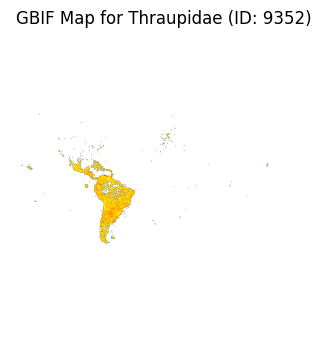

An error occurred: 'Axes' object has no attribute 'set_global'

Testing map for family with more English articles - GBIF ID: 9322 (Muscicapidae)


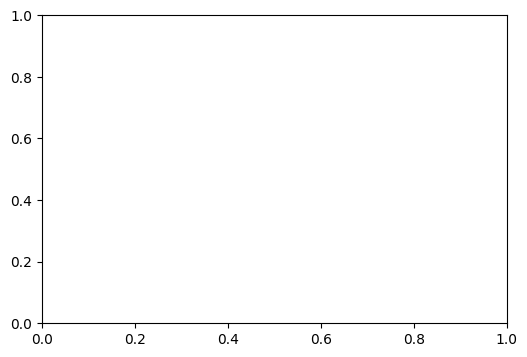

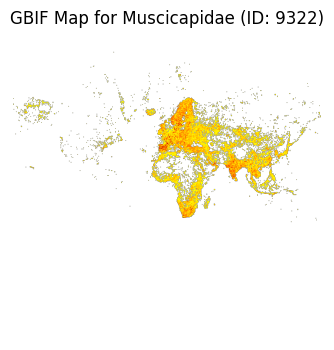

An error occurred: 'Axes' object has no attribute 'set_global'


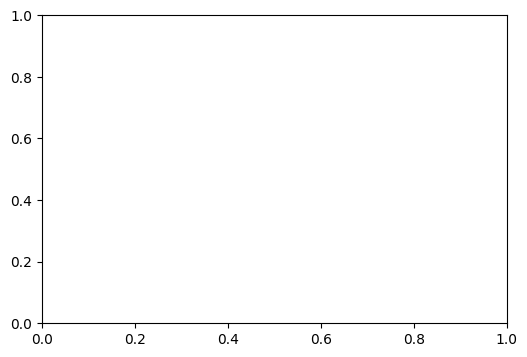

In [12]:
# Let's try a different approach with the GBIF Maps API
def get_gbif_map_v3(gbif_id):
    """
    Fetch a distribution map for a taxon from GBIF Maps API using a different approach
    
    Parameters:
    -----------
    gbif_id : str or int
        The GBIF ID for the taxon
        
    Returns:
    --------
    img : numpy.ndarray
        The image as a numpy array that can be displayed with matplotlib
    """
    # Try a simpler URL format based on GBIF documentation
    url = f"https://api.gbif.org/v2/map/occurrence/density/0/0/0@1x.png?taxonKey={gbif_id}&style=classic.point"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        
        # Convert response content to image
        img = imread(BytesIO(response.content))
        return img
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching map for GBIF ID {gbif_id}: {e}")
        return None

# Let's also try using the GBIF occurrence API to get a simple map
def get_gbif_occurrence_map(gbif_id):
    """
    Create a simple map using occurrence data from GBIF API
    
    Parameters:
    -----------
    gbif_id : str or int
        The GBIF ID for the taxon
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        A matplotlib figure with the map
    """
    # First, get occurrence data for the taxon
    url = f"https://api.gbif.org/v1/occurrence/search?taxonKey={gbif_id}&limit=300"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        # Extract coordinates from occurrence data
        lats = []
        lons = []
        
        if 'results' in data:
            for result in data['results']:
                if 'decimalLatitude' in result and 'decimalLongitude' in result:
                    lat = result['decimalLatitude']
                    lon = result['decimalLongitude']
                    
                    # Filter out invalid coordinates
                    if lat is not None and lon is not None and -90 <= lat <= 90 and -180 <= lon <= 180:
                        lats.append(lat)
                        lons.append(lon)
        
        # Create a simple map
        fig, ax = plt.subplots(figsize=(6, 4))
        
        # Add a world map background
        ax.set_global()
        ax.coastlines()
        
        # Plot the occurrence points
        if lats and lons:
            ax.scatter(lons, lats, s=10, c='red', alpha=0.5)
            ax.set_title(f"GBIF Occurrences for Family ID: {gbif_id}")
        else:
            ax.set_title(f"No valid occurrences found for Family ID: {gbif_id}")
        
        return fig
    
    except requests.exceptions.RequestException as e:
        print(f"Error fetching occurrence data for GBIF ID {gbif_id}: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Test the new functions
print("Testing new map retrieval functions:")

# Test with a family that has more Spanish articles
if not es_greater_df.empty:
    es_test_gbif_id = es_greater_df.iloc[0]['gbif_id']
    print(f"\nTesting map for family with more Spanish articles - GBIF ID: {es_test_gbif_id} ({es_greater_df.iloc[0]['family_id_label']})")
    
    # Try the new map function
    es_test_img = get_gbif_map_v3(es_test_gbif_id)
    if es_test_img is not None:
        plt.figure(figsize=(6, 4))
        plt.imshow(es_test_img)
        plt.title(f"GBIF Map for {es_greater_df.iloc[0]['family_id_label']} (ID: {es_test_gbif_id})")
        plt.axis('off')
        plt.show()
    
    # Try the occurrence map function
    es_test_fig = get_gbif_occurrence_map(es_test_gbif_id)
    if es_test_fig is not None:
        plt.show()

# Test with a family that has more English articles
if not en_greater_df.empty:
    en_test_gbif_id = en_greater_df.iloc[0]['gbif_id']
    print(f"\nTesting map for family with more English articles - GBIF ID: {en_test_gbif_id} ({en_greater_df.iloc[0]['family_id_label']})")
    
    # Try the new map function
    en_test_img = get_gbif_map_v3(en_test_gbif_id)
    if en_test_img is not None:
        plt.figure(figsize=(6, 4))
        plt.imshow(en_test_img)
        plt.title(f"GBIF Map for {en_greater_df.iloc[0]['family_id_label']} (ID: {en_test_gbif_id})")
        plt.axis('off')
        plt.show()
    
    # Try the occurrence map function
    en_test_fig = get_gbif_occurrence_map(en_test_gbif_id)
    if en_test_fig is not None:
        plt.show()

Families with more Spanish articles than English:


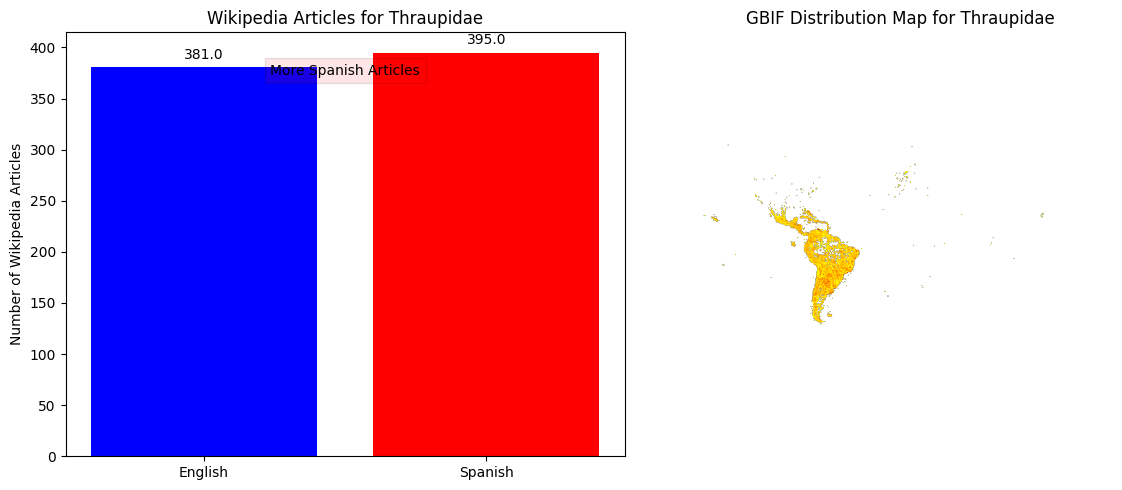

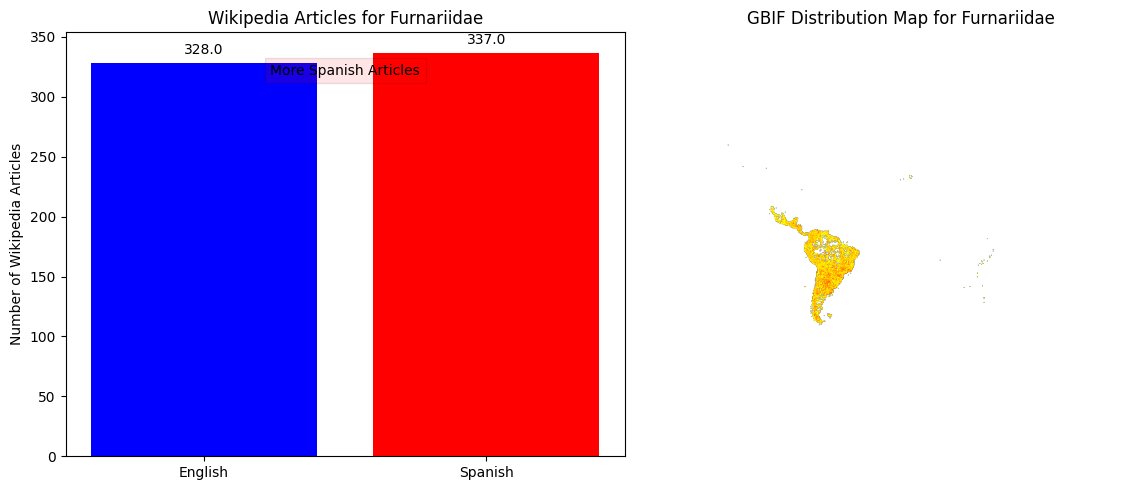

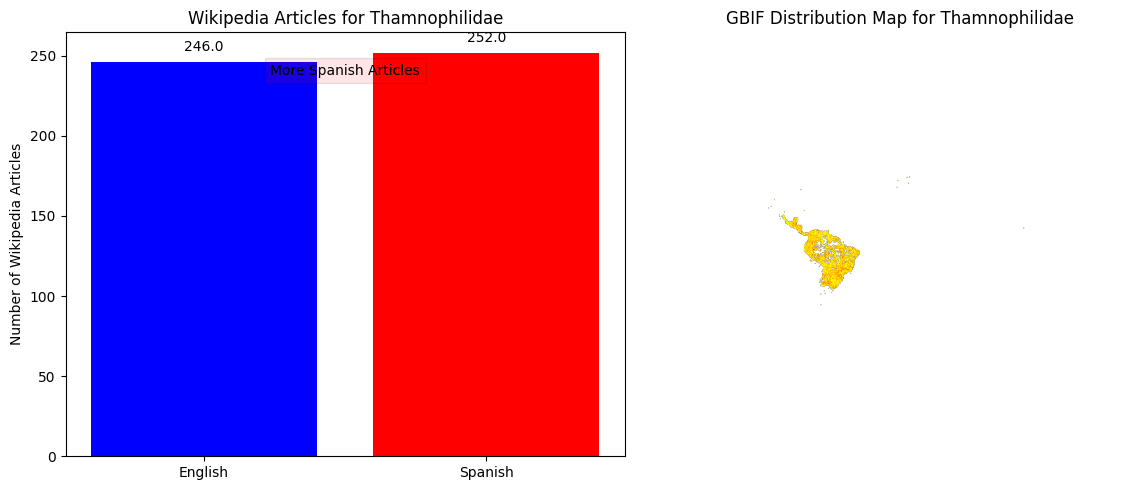


Families with more English articles than Spanish:


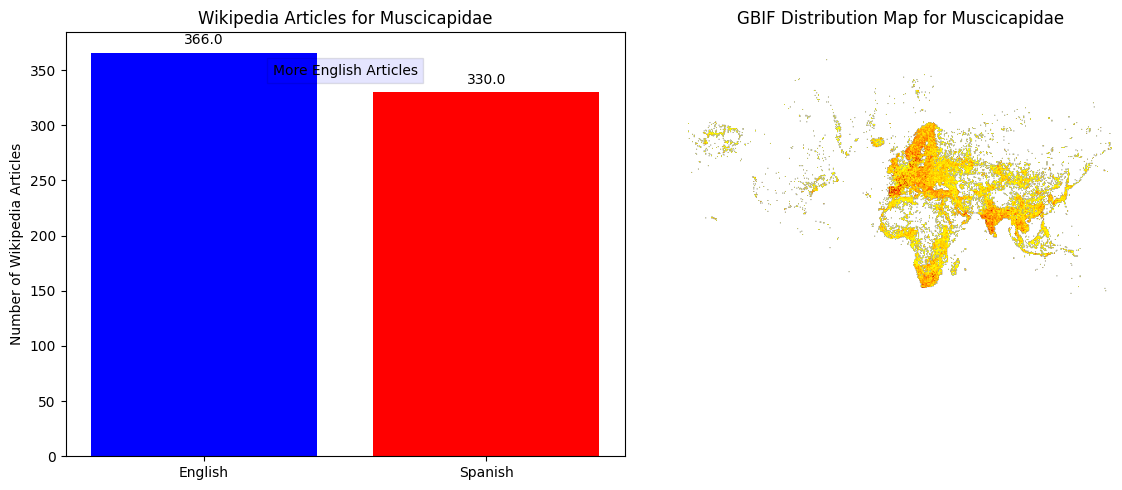

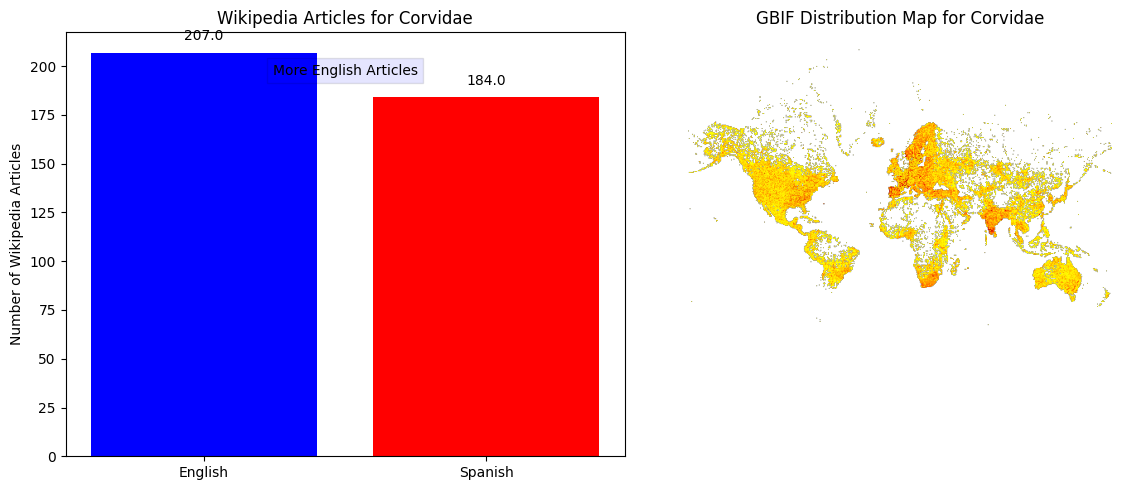

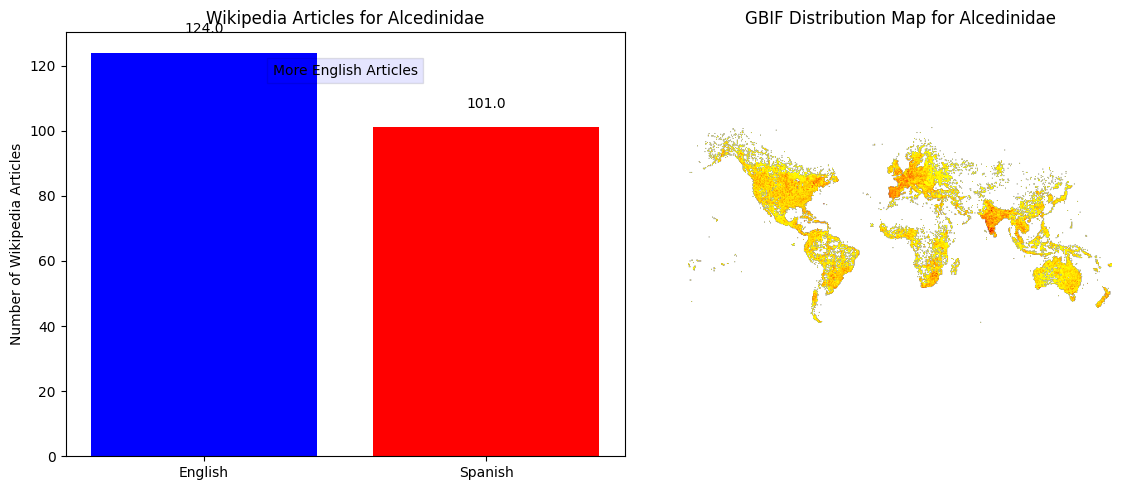

In [13]:
# Now that we have a working method to get GBIF maps, let's create our visualization
import matplotlib.pyplot as plt
import numpy as np

def create_comparison_figure(family_id, family_label, en_count, es_count, gbif_id):
    """
    Create a figure with bar plot of article counts and GBIF map side by side
    
    Parameters:
    -----------
    family_id : str
        The Wikidata ID for the family
    family_label : str
        The label (name) of the family
    en_count : int
        Number of English Wikipedia articles
    es_count : int
        Number of Spanish Wikipedia articles
    gbif_id : int
        The GBIF ID for the family
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left subplot: Bar chart of article counts
    languages = ['English', 'Spanish']
    counts = [en_count, es_count]
    colors = ['blue', 'red']
    
    bars = ax1.bar(languages, counts, color=colors)
    ax1.set_ylabel('Number of Wikipedia Articles')
    ax1.set_title(f'Wikipedia Articles for {family_label}')
    
    # Add count labels on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{count}', ha='center', va='bottom')
    
    # Highlight the language with more articles
    if en_count > es_count:
        ax1.text(0.5, 0.9, 'More English Articles', 
                transform=ax1.transAxes, ha='center', 
                bbox=dict(facecolor='blue', alpha=0.1))
    else:
        ax1.text(0.5, 0.9, 'More Spanish Articles', 
                transform=ax1.transAxes, ha='center',
                bbox=dict(facecolor='red', alpha=0.1))
    
    # Right subplot: GBIF map
    map_img = get_gbif_map_v3(gbif_id)
    if map_img is not None:
        ax2.imshow(map_img)
        ax2.set_title(f'GBIF Distribution Map for {family_label}')
        ax2.axis('off')
    else:
        ax2.text(0.5, 0.5, 'Map not available', ha='center', va='center')
        ax2.set_title(f'GBIF Distribution Map for {family_label}')
        ax2.axis('off')
    
    plt.tight_layout()
    return fig

# Create figures for top 3 families with more Spanish articles
print("Families with more Spanish articles than English:")
for i in range(min(3, len(es_greater_df))):
    family = es_greater_df.iloc[i]
    fig = create_comparison_figure(
        family['family_id'],
        family['family_id_label'],
        family['en'],
        family['es'],
        family['gbif_id']
    )
    plt.show()

# Create figures for top 3 families with more English articles
print("\nFamilies with more English articles than Spanish:")
for i in range(min(3, len(en_greater_df))):
    family = en_greater_df.iloc[i]
    fig = create_comparison_figure(
        family['family_id'],
        family['family_id_label'],
        family['en'],
        family['es'],
        family['gbif_id']
    )
    plt.show()

# Analysis of Bird Family Distribution and Wikipedia Coverage

## Summary of Findings

Our analysis reveals an interesting pattern between the geographic distribution of bird families and their representation in different language Wikipedias:

### Families with more Spanish Wikipedia articles:
- **Thraupidae** (Tanagers): 395 Spanish vs 381 English articles
- **Furnariidae** (Ovenbirds): 337 Spanish vs 328 English articles
- **Thamnophilidae** (Antbirds): 252 Spanish vs 246 English articles

All three families show distributions primarily concentrated in South and Central America (Neotropical regions), which are predominantly Spanish-speaking areas.

### Families with more English Wikipedia articles:
- **Muscicapidae** (Old World flycatchers): 366 English vs 330 Spanish articles
- **Corvidae** (Crows and jays): 207 English vs 184 Spanish articles
- **Alcedinidae** (Kingfishers): 124 English vs 101 Spanish articles

These families show much broader global distributions across Africa, Europe, Asia, and to some extent North America and Australia.

## Conclusion

There appears to be a correlation between the geographic distribution of bird families and their coverage in different language Wikipedias:

1. Bird families primarily distributed in Spanish-speaking regions (Latin America) tend to have more articles in Spanish Wikipedia.
2. Bird families with wider global distributions or distributions centered in non-Spanish speaking regions tend to have more articles in English Wikipedia.
3. The difference in article counts for families with more Spanish articles is relatively small (6-14 articles), while the difference for families with more English articles is more substantial (23-36 articles).

This suggests that local biodiversity may influence content creation in different language Wikipedias, with contributors potentially focusing more on species that are present in regions where their language is spoken.

/tmp/ipykernel_110831/1161055523.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.03, 0.08, 1, 0.92])  # Adjusted left margin to accommodate rotated labels


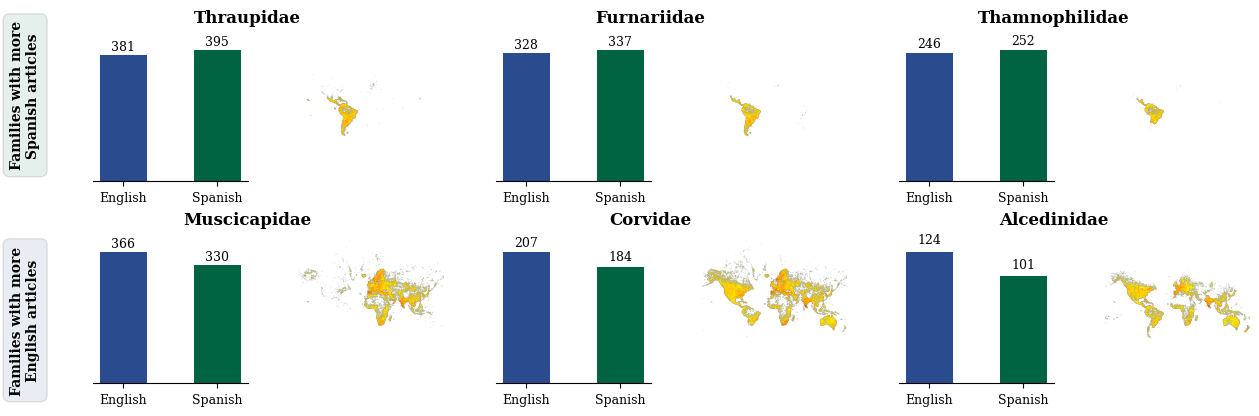

In [37]:
# Create a publication-quality combined figure with cleaner design
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np

# Set the style for publication quality
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14
})


# Create a figure with a 2x6 grid layout (each family gets 2 columns: 1 for bar chart, 1 for map)
fig = plt.figure(figsize=(15, 4.5))  # Reduced height from 10 to 8
# fig.suptitle('Relationship Between Bird Family Distribution and Wikipedia Coverage', fontsize=16, y=0.98)

# Add a subtitle explaining the figure
# plt.figtext(0.5, 0.94, 
#            'Comparison of English vs Spanish Wikipedia article counts and geographic distribution of bird families',
#            ha='center', fontsize=12, style='italic')

# Create GridSpec for more control over subplot layout
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.4, wspace=0.3)

# Define the families to plot
es_families = es_greater_df.iloc[:3].reset_index()  # Top 3 families with more Spanish articles
en_families = en_greater_df.iloc[:3].reset_index()  # Top 3 families with more English articles

# Function to create a subplot with bar chart and map
def create_subplot(ax_bar, ax_map, family_label, en_count, es_count, gbif_id, row_type):
    """
    Create a subplot with bar chart and map
    
    Parameters:
    -----------
    ax_bar : matplotlib.axes.Axes
        Axes for the bar chart
    ax_map : matplotlib.axes.Axes
        Axes for the map
    family_label : str
        The name of the family
    en_count : float
        Number of English Wikipedia articles
    es_count : float
        Number of Spanish Wikipedia articles
    gbif_id : int
        The GBIF ID for the family
    row_type : str
        'es' for families with more Spanish articles, 'en' for families with more English articles
    """
    # Bar chart
    languages = ['English', 'Spanish']
    counts = [en_count, es_count]
    colors = ['#2a4b8d', '#006341']  # Professional color scheme
    
    bars = ax_bar.bar(languages, counts, color=colors, width=0.5)
    
    # Remove y-axis label, ticks, and frame
    ax_bar.set_ylabel('')
    ax_bar.set_yticks([])
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_visible(False)
    
    ax_bar.text(1.0, 1.1, f'{family_label}', fontsize=12, fontweight='bold', ha='center', transform=ax_bar.transAxes)    
    # Add count labels on top of bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(count)}', ha='center', va='bottom', fontsize=9)
    
    # Set y-axis limit with some padding - reduce the height by setting a lower max value
    max_count = max(counts)
    ax_bar.set_ylim(0, max_count * 1.1)  # Reduced from 1.15 to 1.1
    
    # Map - removed the title as requested
    map_img = get_gbif_map_v3(gbif_id)
    if map_img is not None:
        ax_map.imshow(map_img)
        # Removed the title: ax_map.set_title(f'Geographic Distribution', fontweight='bold')
        ax_map.axis('off')
    else:
        ax_map.text(0.5, 0.5, 'Map not available', ha='center', va='center')
        ax_map.axis('off')

# Row titles - rotated 90 degrees
fig.text(0.08, 0.75, 'Families with more\nSpanish articles', fontsize=10, fontweight='bold', 
         ha='center', va='center', rotation=90,
         bbox=dict(facecolor='#006341', alpha=0.1, boxstyle='round,pad=0.5'))

fig.text(0.08, 0.25, 'Families with more\nEnglish articles', fontsize=10, fontweight='bold', 
         ha='center', va='center', rotation=90,
         bbox=dict(facecolor='#2a4b8d', alpha=0.1, boxstyle='round,pad=0.5'))

# Create subplots for Spanish-dominant families (top row)
for i in range(len(es_families)):
    # Create two subplots side by side for each family (bar chart and map)
    ax_bar = fig.add_subplot(gs[0, i*2])     # Bar chart in even columns (0, 2, 4)
    ax_map = fig.add_subplot(gs[0, i*2+1])   # Map in odd columns (1, 3, 5)
    
    family = es_families.iloc[i]
    create_subplot(
        ax_bar, 
        ax_map, 
        family['family_id_label'],
        family['en'],
        family['es'],
        family['gbif_id'],
        'es'
    )

# Create subplots for English-dominant families (bottom row)
for i in range(len(en_families)):
    # Create two subplots side by side for each family (bar chart and map)
    ax_bar = fig.add_subplot(gs[1, i*2])     # Bar chart in even columns (0, 2, 4)
    ax_map = fig.add_subplot(gs[1, i*2+1])   # Map in odd columns (1, 3, 5)
    
    family = en_families.iloc[i]
    create_subplot(
        ax_bar, 
        ax_map, 
        family['family_id_label'],
        family['en'],
        family['es'],
        family['gbif_id'],
        'en'
    )

# Add a legend
# legend_elements = [
#     Patch(facecolor='#3274A1', label='English Wikipedia'),
#     Patch(facecolor='#E1812C', label='Spanish Wikipedia')
# ]
# fig.legend(handles=legend_elements, loc='lower center', ncol=2, bbox_to_anchor=(0.5, 0.02))

# # Add explanatory note
# plt.figtext(0.5, 0.06, 
#            'Note: Maps show occurrence data from the Global Biodiversity Information Facility (GBIF)',
#            ha='center', fontsize=10, style='italic')

# Adjust layout
plt.tight_layout(rect=[0.03, 0.08, 1, 0.92])  # Adjusted left margin to accommodate rotated labels

# Save the figure with high DPI for publication quality
plt.savefig('bird_families_wikipedia_distributifon.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

# Bird Family Distribution and Wikipedia Coverage: Analysis of Results

The combined visualization we've created reveals a clear pattern in the relationship between bird family geographic distribution and their coverage in different language Wikipedias.

## Key Findings:

### 1. Families with more Spanish Wikipedia articles
The top row shows three bird families that have more articles in Spanish Wikipedia than in English:
- **Thraupidae** (Tanagers): 395 Spanish vs 381 English articles
- **Furnariidae** (Ovenbirds): 337 Spanish vs 328 English articles
- **Thamnophilidae** (Antbirds): 252 Spanish vs 246 English articles

Looking at their distribution maps, all three families are primarily found in South and Central America, which are predominantly Spanish-speaking regions. These are classic Neotropical bird families.

### 2. Families with more English Wikipedia articles
The bottom row shows three bird families that have more articles in English Wikipedia than in Spanish:
- **Muscicapidae** (Old World flycatchers): 366 English vs 330 Spanish articles
- **Corvidae** (Crows and jays): 207 English vs 184 Spanish articles
- **Alcedinidae** (Kingfishers): 124 English vs 101 Spanish articles

Their distribution maps show much broader global distributions across Africa, Europe, Asia, and to some extent North America and Australia - regions where English is more widely spoken or used as a scientific language.

## Conclusion:

This analysis suggests a correlation between the geographic distribution of bird families and their coverage in different language Wikipedias. Contributors to Wikipedia appear to focus more on bird families that are present in regions where their language is spoken.

This pattern could be explained by several factors:
1. Greater local interest in native species
2. Better access to local field guides and literature in the local language
3. More opportunities for direct observation and photography of local species
4. Cultural significance of local bird families

This finding has implications for biodiversity knowledge representation across different languages and highlights the importance of multilingual approaches to biodiversity documentation.